# Change Point Analysis 

## Imports

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import numpy as np
import ruptures as rpt

In [31]:
def find_data_folder(folder_path, start_path='/content/drive'):
  '''
    :file_path: The complete path of the folder that includes the files.
    :start_path: The root folder on Drive from which we start the search.
  '''
  #Search the root folder of the data and if found, continue searching the full path.
  start_data_folder = folder_path.split('/')[0]
  for root, dirs, files in os.walk(start_path):
      if start_data_folder in dirs:
          return os.path.join(root, folder_path)
  raise Exception(f"{start_data_folder} folder not found. Please check the directory structure.")

def read_store_files(files_path, file_type='.csv'):
  '''
    :files_path: The complete Drive path that includes the files
  '''

  data_list = []
  files_names = []
  for file in os.listdir(files_path):
    if file.endswith(file_type):
      file_path = os.path.join(files_path, file)
      if file_type == '.csv':
        data = pd.read_csv(file_path)
      elif file_type == '.xlsx':
        data = pd.read_excel(file_path)

      data_list.append(data)
      files_names.append(file)

  return data_list, files_names

def zero_pad_filenames(annotation_files_names):
    # Create a list to hold the zero-padded filenames
    padded_filenames = []

    for filename in annotation_files_names:
        # Extract the number part from the filename
        parts = re.split(r'(\d+)', filename)
        # Zero-pad the number part
        parts[1] = parts[1].zfill(2)
        # Reconstruct the filename
        padded_filename = ''.join(parts)
        padded_filenames.append(padded_filename)

    return padded_filenames

def sort_data(files_names, data):
    # Get the zero-padded filenames
    padded_filenames = zero_pad_filenames(files_names)
    
    # Create a list of tuples (padded_filename, original_filename, annotation_data)
    combined_list = list(zip(padded_filenames, files_names, data))

    # Sort the combined list based on the zero-padded filenames
    combined_list.sort()

    # Unzip the sorted list back into the separate components
    sorted_filenames = [original_filename for _, original_filename, _ in combined_list]
    sorted_data = [data for _, _, data in combined_list]

    return sorted_filenames, sorted_data

In [32]:
# Retrieve folders
annotations_folder = 'CASE_full/data/interpolated/annotations'
physiological_folder = 'CASE_full/data/interpolated/physiological'
metadata_folder = 'CASE_full/metadata'

print(f'Path of Annotation files: {annotations_folder}')
print(f'Path of Physiological files: {physiological_folder}')
print(f'Path of metadata files: {metadata_folder}')

# Retrieve data files
annotation_data, annotation_files_names = read_store_files(annotations_folder)
physio_data, physio_files_names = read_store_files(physiological_folder)

annotation_files_names, annotation_data = sort_data(annotation_files_names, annotation_data)
physio_files_names, physio_data = sort_data(physio_files_names, physio_data)

print(f'Number of Annotation files: {len(annotation_data)}\nNames: {annotation_files_names}')
print(f'Number of Physiological files: {len(physio_data)}\nNames: {physio_files_names}')

# Retrieve metadata
metadata, metadata_names = read_store_files(metadata_folder,'.xlsx')
print(f'Metadata names: {metadata_names}')

# Strip column names
for i in range(len(metadata)):
  metadata[i].columns = metadata[i].columns.str.strip()

for i, file in enumerate(metadata_names):
  if file == 'videos.xlsx':
    videos_data = metadata[i].drop(metadata[i].columns[2:], axis=1).drop([0]).rename(columns={'Video-label': 'label', 'Video-ID': 'video_id'}).dropna()
    videos_data['video_id'] = videos_data['video_id'].astype(int)
  elif file == 'participants.xlsx':
    participant_data = metadata[i].rename(columns={'Participant-ID': 'participant_id', 'Age-Group': 'age_group', 'Video Sequence Used': 'sequence'})

  elif file == 'videos_duration_num.xlsx':
    duration_data = metadata[i].rename(columns={'video-ID': 'video_id', 'video-duration (in ms)': 'duration'})

  elif file == 'seqs_order_num.xlsx':
    sequence_order_data = metadata[i]


del metadata

Path of Annotation files: CASE_full/data/interpolated/annotations
Path of Physiological files: CASE_full/data/interpolated/physiological
Path of metadata files: CASE_full/metadata
Number of Annotation files: 30
Names: ['sub_1.csv', 'sub_2.csv', 'sub_3.csv', 'sub_4.csv', 'sub_5.csv', 'sub_6.csv', 'sub_7.csv', 'sub_8.csv', 'sub_9.csv', 'sub_10.csv', 'sub_11.csv', 'sub_12.csv', 'sub_13.csv', 'sub_14.csv', 'sub_15.csv', 'sub_16.csv', 'sub_17.csv', 'sub_18.csv', 'sub_19.csv', 'sub_20.csv', 'sub_21.csv', 'sub_22.csv', 'sub_23.csv', 'sub_24.csv', 'sub_25.csv', 'sub_26.csv', 'sub_27.csv', 'sub_28.csv', 'sub_29.csv', 'sub_30.csv']
Number of Physiological files: 30
Names: ['sub_1.csv', 'sub_2.csv', 'sub_3.csv', 'sub_4.csv', 'sub_5.csv', 'sub_6.csv', 'sub_7.csv', 'sub_8.csv', 'sub_9.csv', 'sub_10.csv', 'sub_11.csv', 'sub_12.csv', 'sub_13.csv', 'sub_14.csv', 'sub_15.csv', 'sub_16.csv', 'sub_17.csv', 'sub_18.csv', 'sub_19.csv', 'sub_20.csv', 'sub_21.csv', 'sub_22.csv', 'sub_23.csv', 'sub_24.csv', '

In [53]:
def downsample_data(df, factor=10):
    return df.groupby(np.arange(len(df)) // factor).mean()

def detect_change_points(df, model="rbf", pen=20):
    algo = rpt.Pelt(model=model).fit(df.values)
    change_points = algo.predict(pen=pen)
    return change_points

def combine_valence_arousal(valence, arousal):
    return valence['valence'].abs() + arousal['arousal'].abs()

In [56]:
# Initialize a list to store the change-point results for all participants
important_segments_all_participants  = []
dfs = []
pens = [5,10,15,20,25,30,35]

for participant_index in range(len(annotation_data)):
    print(f'Processing participant {participant_index + 1}')
    
    # Extract the annotation data for the current participant
    annotations = annotation_data[participant_index]
    
    time_df = annotations['jstime'].to_frame()
    valence_df = annotations['valence'].to_frame()
    arousal_df = annotations['arousal'].to_frame()
        
    # Combine valence and arousal scores
    combined_df = combine_valence_arousal(valence_df, arousal_df)
    dfs.append([valence_df, arousal_df, combined_df])
    
    # Detect change-points in the combined series
    combined_change_points = detect_change_points(combined_df)
    
    important_segments_all_participants.append(combined_change_points)

Processing participant 1
Processing participant 2
Processing participant 3
Processing participant 4
Processing participant 5
Processing participant 6
Processing participant 7
Processing participant 8
Processing participant 9
Processing participant 10
Processing participant 11
Processing participant 12
Processing participant 13
Processing participant 14
Processing participant 15
Processing participant 16
Processing participant 17
Processing participant 18
Processing participant 19
Processing participant 20
Processing participant 21
Processing participant 22
Processing participant 23
Processing participant 24
Processing participant 25
Processing participant 26
Processing participant 27
Processing participant 28
Processing participant 29
Processing participant 30


(<Figure size 1000x200 with 1 Axes>, [<AxesSubplot: >])

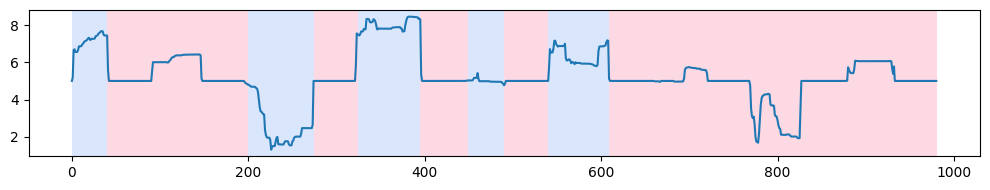

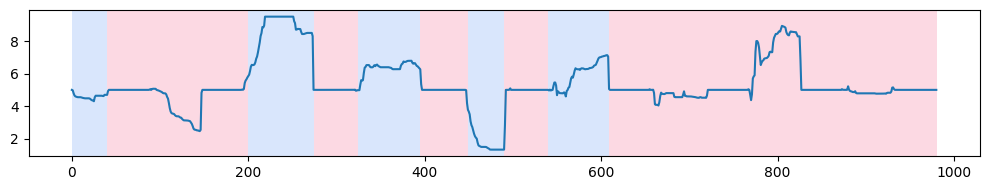

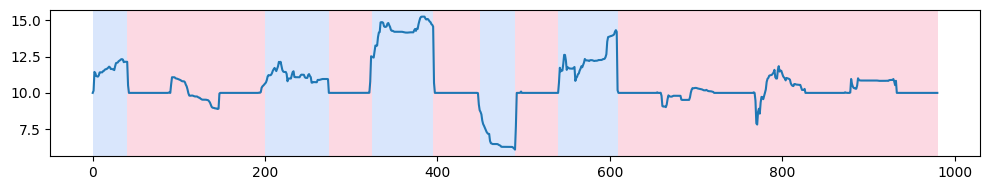

In [57]:
# Display segments

rpt.display(dfs[2][0].values, important_segments_all_participants[2])
rpt.display(dfs[2][1].values, important_segments_all_participants[2])
rpt.display(dfs[2][2].values, important_segments_all_participants[2])

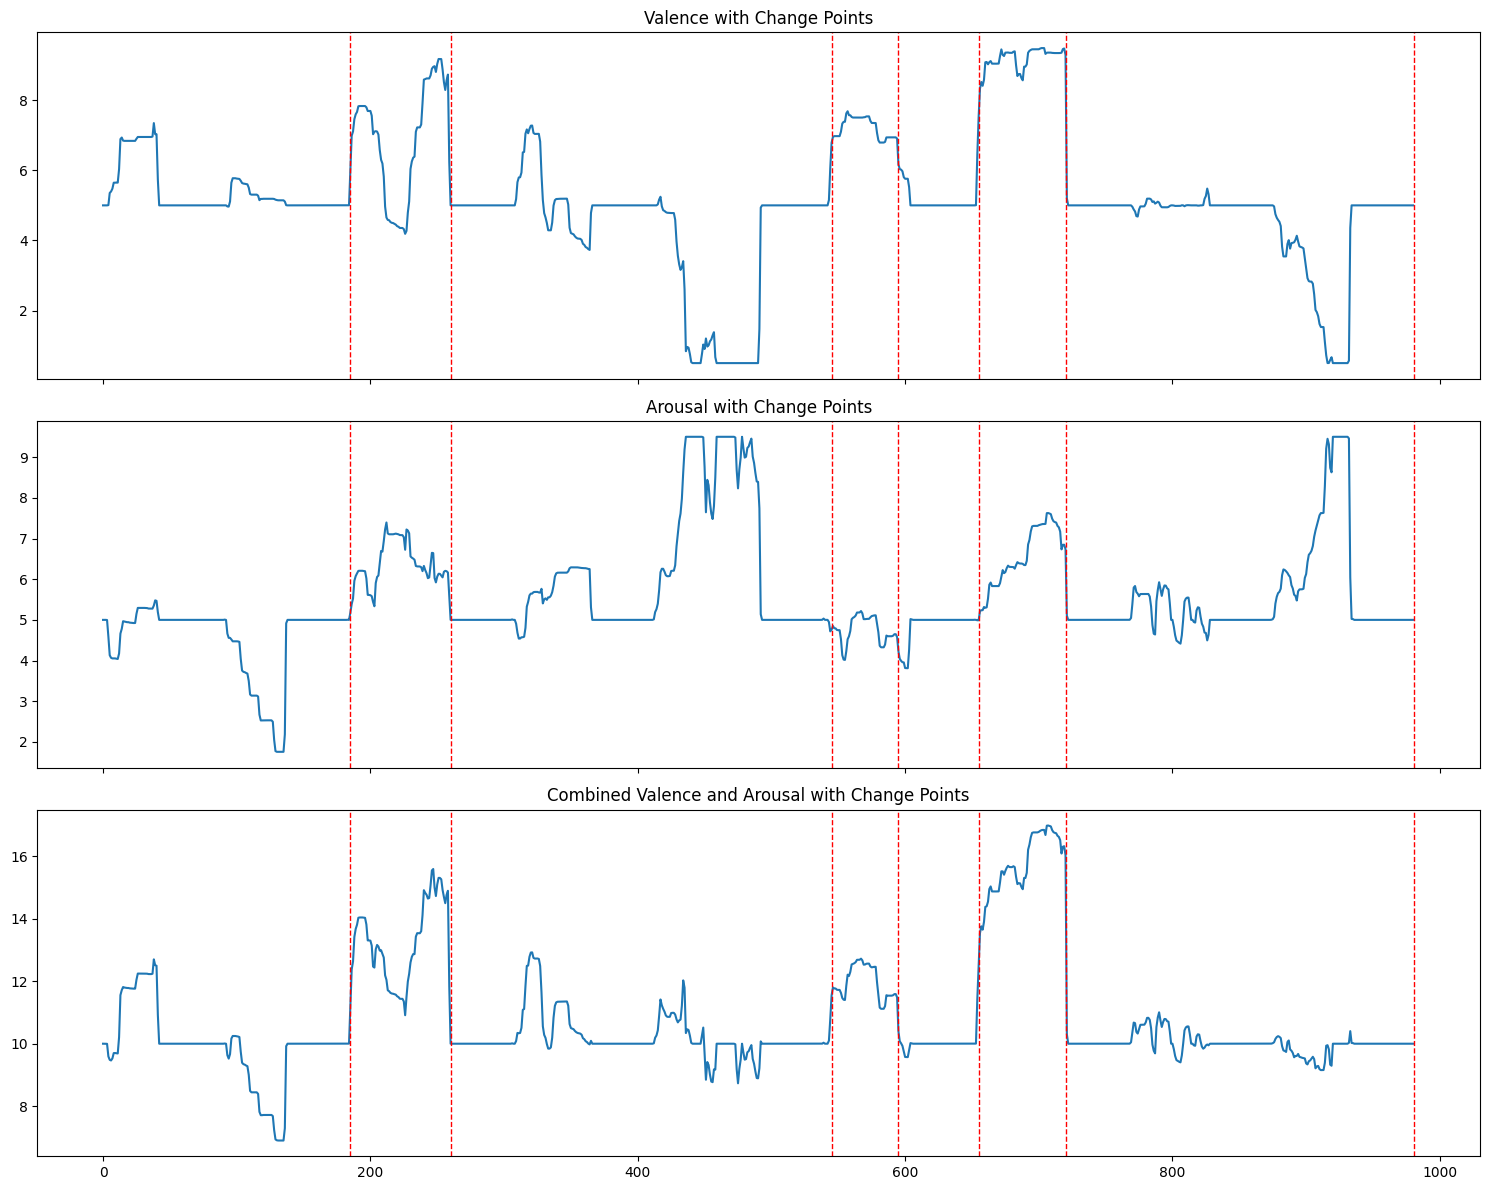

In [21]:
# Plot valence, arousal, and combined signal for the first participant
participant_index = 0

# Plotting the results
fig, axs = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Plot valence change points
axs[0].plot(dfs[participant_index][0].values, label='Valence')
axs[0].set_title('Valence with Change Points')
for cp in important_segments_all_participants[participant_index]:
    axs[0].axvline(x=cp, color='red', linestyle='--', linewidth=1)

# Plot arousal change points
axs[1].plot(dfs[participant_index][1].values, label='Arousal')
axs[1].set_title('Arousal with Change Points')
for cp in important_segments_all_participants[participant_index]:
    axs[1].axvline(x=cp, color='red', linestyle='--', linewidth=1)

# Plot combined signal change points
axs[2].plot(dfs[participant_index][2].values, label='Combined Valence + Arousal')
axs[2].set_title('Combined Valence and Arousal with Change Points')
for cp in important_segments_all_participants[participant_index]:
    axs[2].axvline(x=cp, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()